# **Jellyfish Classification with Transfer Learning**
## By Sebastian Mora -  A01746423
### 11-10-23



In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Introduction

This project involves fine-tuning a computer vision model to classify six types of jellyfish. Fine-tuning adapts a pre-trained model to recognize the unique features of each jellyfish species. By leveraging existing knowledge from a broad dataset, the model is tailored to this specific classification task.

The significance of this project lies in its applications for marine biology, environmental monitoring, and conservation. An accurately fine-tuned model can automate jellyfish identification, aiding researchers in population tracking and understanding their ecological impact. This approach contributes to efficient marine ecosystem management and conservation efforts.

## Dataset Description, Import and Normalization

The jellyfish dataset encompasses six distinct classes: 'Moon_jellyfish,' 'barrel_jellyfish,' 'blue_jellyfish,' 'compass_jellyfish,' 'lions_mane_jellyfish,' and 'mauve_stinger_jellyfish.' Each class represents a unique species, capturing the diverse visual characteristics of these jellyfish. This dataset serves as the foundation for training a computer vision model, enabling it to differentiate and classify these specific jellyfish species accurately.

Since we are trying to fine tune de Xception model, we need to normalize the iamges between [-1,1].

In [3]:
from keras.preprocessing import image_dataset_from_directory

# Change this depending on where you are running this script and where you have the dataset
data_dir = "/content/drive/MyDrive/jellyfish_dataset"


# Load train dataset
train_dataset = image_dataset_from_directory(
    data_dir + "/train",
    image_size=(224,224),
    batch_size=64,
)

# Load validation dataset
valid_dataset = image_dataset_from_directory(
    data_dir + "/valid",
    image_size=(224,224),
    batch_size=64,
)

# Load test dataset
test_dataset = image_dataset_from_directory(
    data_dir + "/test",
    image_size=(224,224),
    batch_size=64,
)

# Normalizing pixels tp [-1, 1]
def normalize_img(img, label):
    return (tf.cast(img, tf.float32) / 127.5) - 1, label

class_names = train_dataset.class_names
print("Class names : ",class_names)

#train_dataset = train_dataset.map(normalize_img)
#valid_dataset = valid_dataset.map(normalize_img)
#test_dataset = test_dataset.map(normalize_img)

Found 900 files belonging to 6 classes.
Found 39 files belonging to 6 classes.
Found 40 files belonging to 6 classes.
Class names :  ['Moon_jellyfish', 'barrel_jellyfish', 'blue_jellyfish', 'compass_jellyfish', 'lions_mane_jellyfish', 'mauve_stinger_jellyfish']


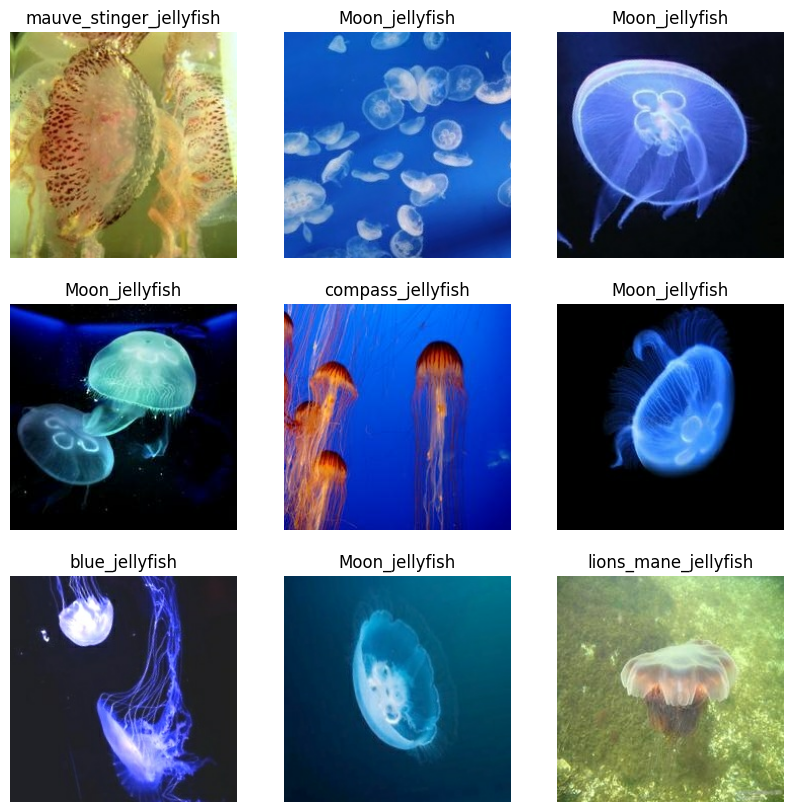

In [4]:
images, labels = next(iter(train_dataset))

# Function for displaying images
def plot_images(images, labels):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy()
        plt.imshow(img.astype("uint8"))

        plt.title(class_names[labels[i]])
        plt.axis("off")

plot_images(images, labels)

## Model Architecture Description

Xception is a model created in 2017, it most relevant feature is the "extreme" use of inception like layers. At first, we can see that it has 87 MB of trainable parameters, but we are going to change the output layer of the model to a softmax(6) output layer, then we freeze all the layers of the original Xception model, to then un-freeze the las 22 layers of the model, leaving the final model with 79 MB of params, of which only 28 MB are trainable.

In [24]:
xception = tf.keras.applications.Xception(include_top=False, weights='imagenet')
xception.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, None, None, 3)]      0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, None, None, 32)       864       ['input_10[0][0]']            
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, None, None, 32)       128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activat

In [ ]:
x = xception.layers[-1].output
x = keras.layers.GlobalAveragePooling2D()(x)

output = keras.layers.Dense(units=6, activation='softmax')(x)
model = keras.Model(inputs=xception.input, outputs=output)

for layer in model.layers[:-22]:
    layer.trainable = False

model.summary()

## Testing the first attempt of training the model
- Adam Optimzer
- Learning Rate : 0.001
- Epochs 5

In [ ]:
history = model.fit(x=train_dataset,
            steps_per_epoch=len(train_dataset),
            validation_data=valid_dataset,
            validation_steps=len(valid_dataset),
            epochs=5,
)

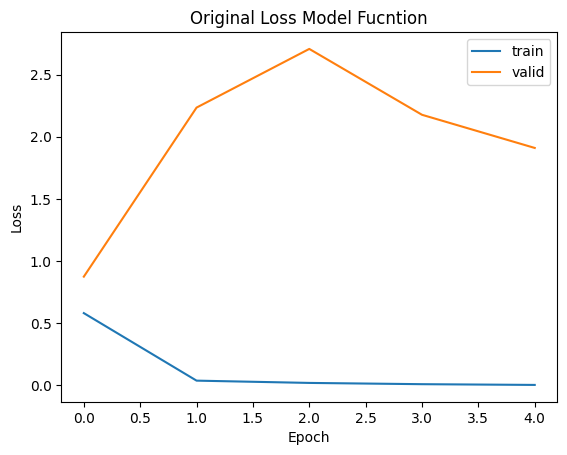

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Original Loss Model Fucntion')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'])
plt.show()

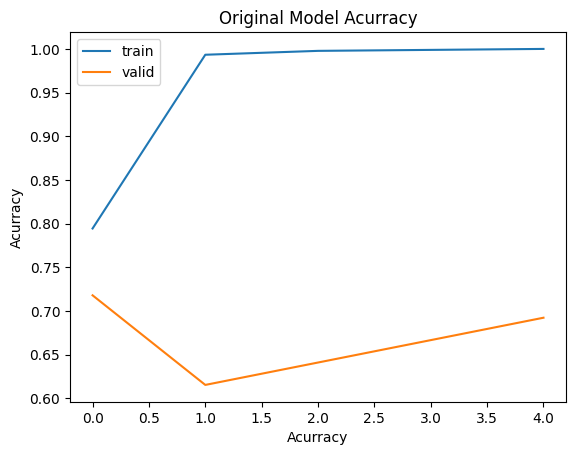

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Original Model Acurracy')
plt.ylabel('Acurracy')
plt.xlabel('Acurracy')
plt.legend(['train', 'valid'])
plt.show()

40/40 [==============================] - 15s 328ms/step


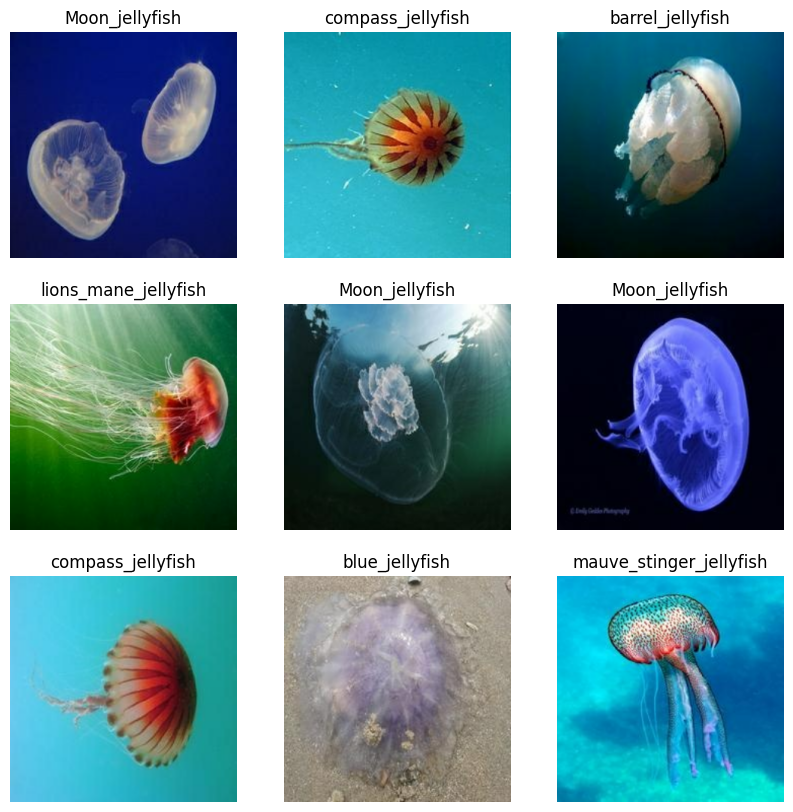

In [ ]:
real_labels = []
for images, labels in test_dataset:
    real_labels.extend(labels.numpy())
real_labels = np.array(real_labels)

images, labels = next(iter(test_dataset))

predictions = model.predict(x=images, steps=len(images), verbose=1)

pred_labels = np.argmax(predictions, axis=1)
plot_images(images, pred_labels)

In [32]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[6 0 0 0 0 0]
 [0 5 0 0 0 0]
 [1 0 5 0 0 1]
 [0 0 0 6 1 0]
 [0 0 0 0 8 0]
 [0 0 0 1 0 6]]


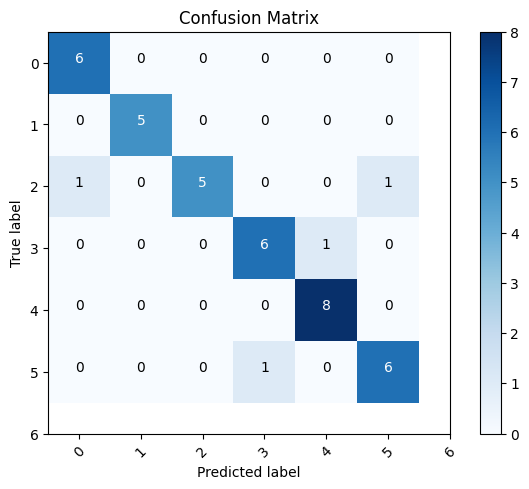

In [ ]:
cm = confusion_matrix(y_true=labels, y_pred=pred_labels)


cm_plot_labels = ['0','1','2','3','4','5', '6']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

## Initial Results Observations

With the Xception model, we see clearly an overfit, even if the confussion matrix dosent look too bad, in the training and evaluation graphics we can see the overfit. In this new aproach I fine tuned a much more simple model called EfficentNet (B0), by unfreezing the las 26 layers that aren a Batch Normalization.

## Attempting to Improve the Model



In [40]:
def build_model(num_classes):
    inputs = keras.layers.Input(shape=(224, 224, 3))
    model = keras.applications.EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = keras.layers.BatchNormalization()(x)

    top_dropout_rate = 0.3
    x = keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy']
    )
    return model

model = build_model(6)
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_24 (Rescaling)    (None, 224, 224, 3)          0         ['input_15[0][0]']            
                                                                                                  
 normalization_12 (Normaliz  (None, 224, 224, 3)          7         ['rescaling_24[0][0]']        
 ation)                                                                                           
                                                                                                  
 rescaling_25 (Rescaling)    (None, 224, 224, 3)          0         ['normalization_12[

In [41]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-26:]:
        if not isinstance(layer, keras.layers.BatchNormalization):
            layer.trainable = True

    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy']
    )


unfreeze_model(model)
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_24 (Rescaling)    (None, 224, 224, 3)          0         ['input_15[0][0]']            
                                                                                                  
 normalization_12 (Normaliz  (None, 224, 224, 3)          7         ['rescaling_24[0][0]']        
 ation)                                                                                           
                                                                                                  
 rescaling_25 (Rescaling)    (None, 224, 224, 3)          0         ['normalization_12[

In [42]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(x=train_dataset,
            steps_per_epoch=len(train_dataset),
            validation_data=valid_dataset,
            validation_steps=len(valid_dataset),
            epochs=35,
            callbacks=[early_stopping]
)

Epoch 1/35
15/15 [==============================] - 110s 6s/step - loss: 2.7435 - accuracy: 0.1433 - val_loss: 1.8977 - val_accuracy: 0.1538
Epoch 2/35
15/15 [==============================] - 93s 6s/step - loss: 2.6005 - accuracy: 0.1611 - val_loss: 1.8511 - val_accuracy: 0.1795
Epoch 3/35
15/15 [==============================] - 88s 6s/step - loss: 2.2927 - accuracy: 0.2444 - val_loss: 1.8062 - val_accuracy: 0.2821
Epoch 4/35
15/15 [==============================] - 98s 7s/step - loss: 2.1167 - accuracy: 0.2611 - val_loss: 1.7621 - val_accuracy: 0.3333
Epoch 5/35
15/15 [==============================] - 93s 6s/step - loss: 1.9904 - accuracy: 0.3122 - val_loss: 1.7151 - val_accuracy: 0.3590
Epoch 6/35
15/15 [==============================] - 91s 6s/step - loss: 1.8700 - accuracy: 0.3422 - val_loss: 1.6723 - val_accuracy: 0.3846
Epoch 7/35
15/15 [==============================] - 92s 6s/step - loss: 1.7463 - accuracy: 0.3678 - val_loss: 1.6313 - val_accuracy: 0.4103
Epoch 8/35
15/15 [=

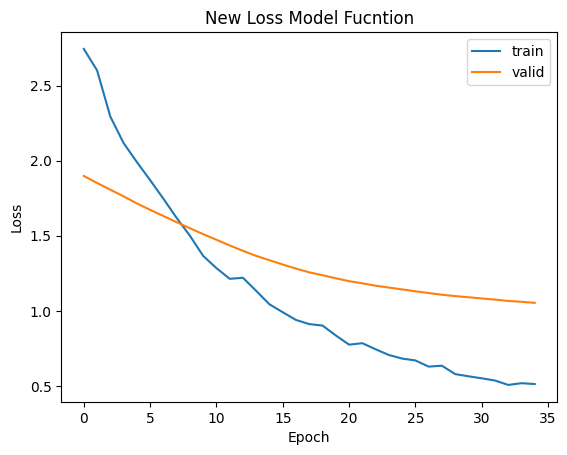

In [43]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('New Loss Model Fucntion')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'])
plt.show()

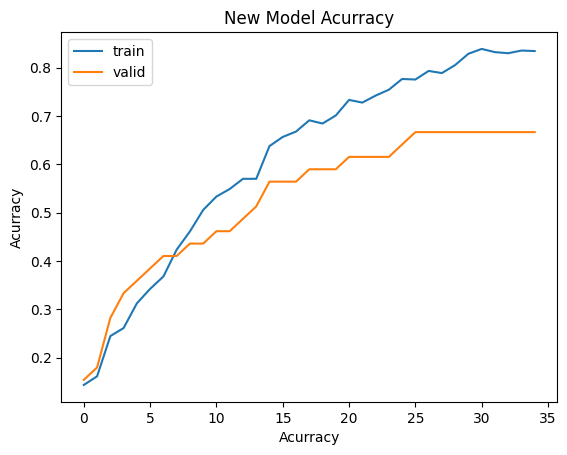

In [44]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('New Model Acurracy')
plt.ylabel('Acurracy')
plt.xlabel('Acurracy')
plt.legend(['train', 'valid'])
plt.show()

40/40 [==============================] - 5s 71ms/step


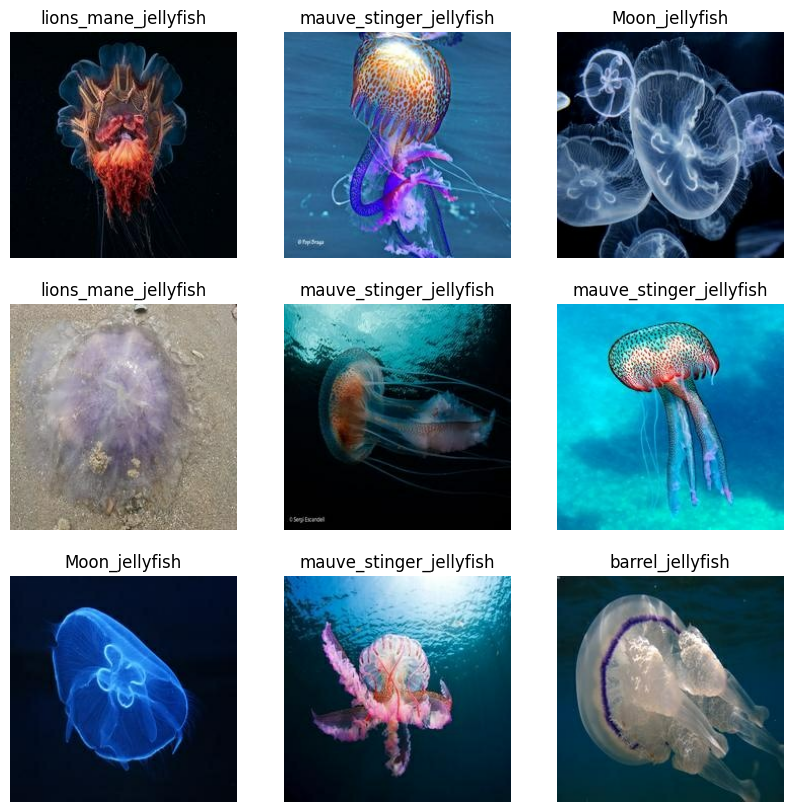

In [45]:
real_labels = []
for images, labels in test_dataset:
    real_labels.extend(labels.numpy())
real_labels = np.array(real_labels)

images, labels = next(iter(test_dataset))

predictions = model.predict(x=images, steps=len(images), verbose=1)

pred_labels = np.argmax(predictions, axis=1)
plot_images(images, pred_labels)

Confusion matrix, without normalization
[[5 0 1 0 0 0]
 [0 5 0 0 0 0]
 [1 1 3 1 1 0]
 [0 0 0 6 1 0]
 [0 0 0 2 6 0]
 [0 0 0 0 1 6]]


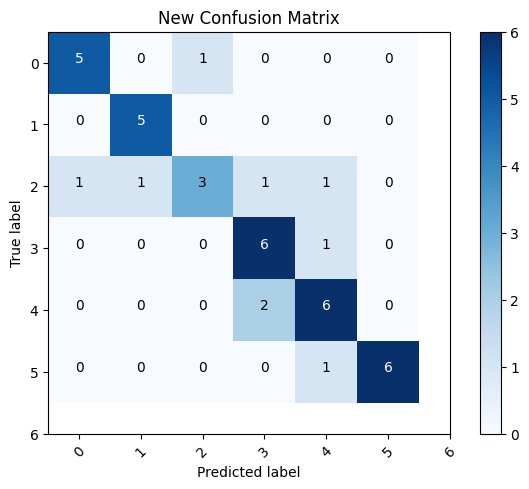

In [46]:
cm = confusion_matrix(y_true=labels, y_pred=pred_labels)
cm_plot_labels = ['0','1','2','3','4','5', '6']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='New Confusion Matrix')

## Conclusions

Having better result with a much more simple model, like efficent net, proves that having a large and complex model dosent always means that we are going to have better results, also searching information about the model we are going to do transfer learning with, like the documentation of EfficientNet, that stays that keeping freeze the Batch Normalization layers can lead to a better result.

### Simple Way to Predict New Images

Saving 12.jpeg to 12.jpeg
Uploaded file "12.jpeg"
1/1 [==============================] - 2s 2s/step


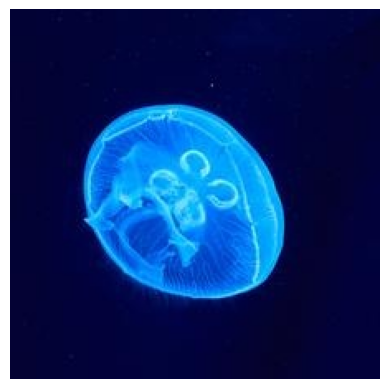

Predicted class: Moon_jellyfish


In [47]:
from keras.preprocessing import image
from google.colab import files


def predict_image(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)
    predicted_class_name = class_names[predicted_class[0]]

    return predicted_class_name, img

uploaded = files.upload()

for fn in uploaded.keys():
    print('Uploaded file "{name}"'.format(name=fn))
    predicted_class, img = predict_image(fn, model)

    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print('Predicted class:', predicted_class)
